# Bayesian Logistic Regression

## Preparing the data

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

X_data = np.loadtxt('data/X.txt')
y_data = np.loadtxt('data/y.txt')

X_data, y_data = shuffle(X_data, y_data)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size=800)

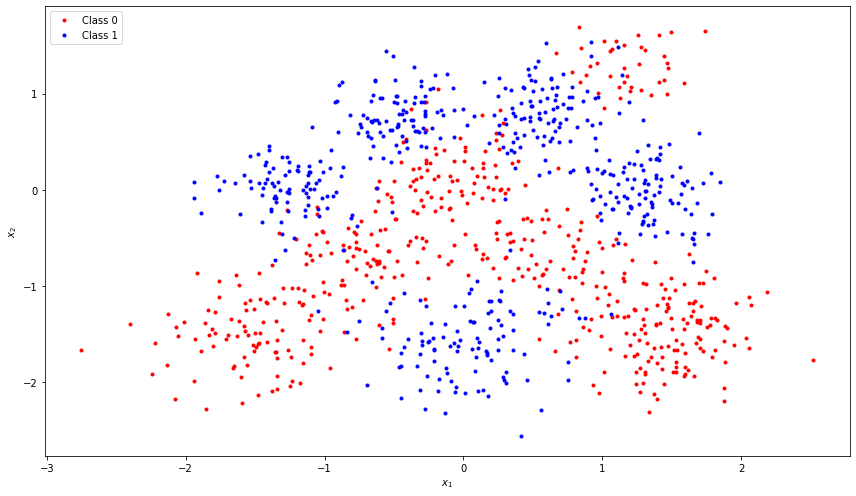

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 7]

def plot_classes(X, y, filename=None):
    figure = plt.figure()
    class0 = y == 0
    class1 = y == 1
    plt.plot(X[class0, 0], X[class0, 1], 'ro', markersize=3, label='Class 0')
    plt.plot(X[class1, 0], X[class1, 1], 'bo', markersize=3, label='Class 1')
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.legend(loc='upper left')
    figure.tight_layout()
    if filename is not None:
        plt.savefig(filename, bbox_inches='tight', pad_inches=0)
    return figure

plot_classes(X_data, y_data, "plots/data.png")
plt.show()

The logistic function forms the core of our classifier:

In [3]:
def logistic(x):
    return 1 / (1 + np.exp(-x))

We define a custom log function that helps prevent divide by zero errors by adding a small value inside the log:

In [4]:
def log(x, epsilon=1e-5):
    """Log function that avoids divide by zero errors"""
    return np.log(x + epsilon)

As the data is not linearly separable, we pass it through a set of radial basis functions centred on the training points to enable our classifier to find non-linear class boundaries.
We also prepend a column of ones to the data, so that it can be dot-producted with the weights.

In [5]:
def prepend_ones(M):
    return np.column_stack((np.ones(M.shape[0]), M))

def expand_inputs(width, data, centers=X_train):
    """Expand data through a set of RBFs with given centres and widths"""
    l = width
    Z = centers
    X = data
    X2 = np.sum(X**2, 1)
    Z2 = np.sum(Z**2, 1)
    ones_Z = np.ones(Z.shape[ 0 ])
    ones_X = np.ones(X.shape[ 0 ])
    r2 = np.outer(X2, ones_Z) - 2 * np.dot(X, Z.T) + np.outer(ones_X, Z2)
    return prepend_ones(np.exp(-0.5 / l**2 * r2))

## Finding the MAP estimate of w

The posterior, likelihood, and prior of the weights are defined by the model:

In [6]:
def log_prior(w, variance):
    return -1 / (2 * variance) * (w.T @ w)

In [7]:
def log_likelihood(w, X, y):
    sigma = logistic(X @ w)
    return np.sum(y * log(sigma)
                  + (1 - y) * log(1 - sigma))

def log_likelihood_gradient(w, X, y):
    return (y - logistic(X @ w)) @ X

In [8]:
def log_posterior(w, X, y, prior_variance):
    return log_likelihood(w, X, y) + log_prior(w, prior_variance)

def posterior_gradient(w, X, y, prior_variance):
    return (y - logistic(X @ w)) @ X - w / prior_variance

We use a gradient-based minimisation function to find $\textbf{w}_\text{map}$. We'll compare the Bayesian solution with the ML solution, so we need to find w_ml as well:

In [9]:
from scipy.optimize import fmin_l_bfgs_b as minimise


def find_w_map(X, y, prior_variance=1, w0=None):
    if w0 is None:
        w0 = np.random.normal(size=X.shape[1])
        
    w_map, *d = minimise(lambda w, X, y, prior_variance: -log_posterior(w, X, y, prior_variance),
                         w0,
                         lambda w, X, y, prior_variance: -posterior_gradient(w, X, y, prior_variance),
                         args=[X, y, prior_variance])
    return w_map

def find_w_ml(X, y, w0=None):
    if w0 is None:
        w0 = np.random.normal(size=X.shape[1])
        
    w_ml, *d = minimise(lambda w, X, y: -log_likelihood(w, X, y),
                        w0,
                        lambda w, X, y: -log_likelihood_gradient(w, X, y),
                        args=[X, y])
    return w_ml

## Predictive distribution and performance metrics

A plot of the predictive distribution is generated by evaluating the predictive function on a grid:

In [10]:
def plot_predictive_distribution(inputs, labels, weights,
                                 predictive_function,
                                 rbf_width, 
                                 filename=None):
    plot_classes(inputs, labels)
    
    x_min, x_max = inputs[:, 0].min() - 0.5, inputs[:, 0].max() + 0.5
    y_min, y_max = inputs[:, 1].min() - 0.5, inputs[:, 1].max() + 0.5
   
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    expanded_grid = expand_inputs(rbf_width,
                                  (np.concatenate((xx.ravel().reshape((-1, 1)),
                                                   yy.ravel().reshape((-1, 1))), 1)))
    
    Z = predictive_function(expanded_grid, weights)
    Z = Z.reshape(xx.shape)

    contours = plt.contour(xx, yy, Z, cmap='RdBu', levels=10, linewidths=2)
    plt.clabel(contours, fontsize=10, fmt='%2.1f', colors='k')
    
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename, bbox_inches='tight', pad_inches=0)
        
    plt.show()

In [11]:
def calculate_hessian(weights, rbf_width, prior_variance):
    # The Hessian will be MxM, where M is the number of features
    M = weights.shape[0]
    
    X_tilde = expand_inputs(rbf_width, X_train)
    
    # Contribution from prior
    h = np.identity(M) / prior_variance 
    
    # Contribution from data
    for x in X_tilde:
        sigma = logistic(weights @ x)
        h += sigma * (1 - sigma) * np.outer(x, x) 
        
    return h            

In [12]:
def direct_prediction(inputs, weights):
     return logistic(inputs @ weights)
    
def laplace_prediction(inputs, weights, rbf_width=0.1, prior_variance=1):
    X_tilde = expand_inputs(rbf_width, X_train)
    sigma = logistic(X_tilde @ weights)
    S_N = np.linalg.inv(calculate_hessian(weights, rbf_width, prior_variance))
    predictive_mean = inputs @ weights
    predictive_variance = np.array([x.T @ S_N @ x for x in inputs])
    return logistic(predictive_mean / np.sqrt(1 + predictive_variance*np.pi/8))

The confusion matrix is the key performance metric we'll be using to evaluate the model:

In [13]:
def confusion_matrix(weights,
                     test_data,
                     test_labels,
                     predictive_function,
                     rbf_width=0.1,
                     prior_variance=1):
    expanded_test_data = expand_inputs(rbf_width, test_data)
    class_probabilities = predictive_function(expanded_test_data, weights)
    
    predicted_class1 = class_probabilities <= 0.5
    predicted_class2 = class_probabilities > 0.5
    
    correctly_predicted_class1 = np.sum(np.logical_and(predicted_class1, test_labels == 0)) / np.sum(test_labels == 0)
    incorrectly_predicted_class1 = np.sum(np.logical_and(predicted_class1, test_labels == 1)) / np.sum(test_labels == 1)
    correctly_predicted_class2 = np.sum(np.logical_and(predicted_class2, test_labels == 1)) / np.sum(test_labels == 1)
    incorrectly_predicted_class2 = np.sum(np.logical_and(predicted_class2, test_labels == 0)) / np.sum(test_labels == 0)

    return np.array([[correctly_predicted_class1, incorrectly_predicted_class2],
                     [incorrectly_predicted_class1, correctly_predicted_class2]])

We'll also use the average log-likelihood to assess how well the trained model fits the data:

In [14]:
def mean_log_likelihood(w, X, y):
    return log_likelihood(w, X, y) / y.size

Group the plots and performance metrics into one function for convenience:

In [15]:
def generate_plots_and_performance_metrics(rbf_width, prior_variance):
    expanded_training_set = expand_inputs(rbf_width, X_train)
    expanded_test_set = expand_inputs(rbf_width, X_test)

    w_map = find_w_map(expanded_training_set, y_train, prior_variance=prior_variance)
    w_ml = find_w_ml(expanded_training_set, y_train)

    print("# ML prediction:")
    plot_predictive_distribution(X_data, y_data, w_ml,
                                 direct_prediction,
                                 rbf_width,
                                 filename=f"plots/bayesian_logistic_classification/predictive_distribution_ML_width_{rbf_width}.png")
    print("# MAP prediction:")
    plot_predictive_distribution(X_data, y_data, w_map,
                                 direct_prediction,
                                 rbf_width,
                                 filename=f"plots/bayesian_logistic_classification/predictive_distribution_MAP_width_{rbf_width}_prior_variance_{prior_variance}.png")
    print("# Laplace prediction:")
    plot_predictive_distribution(X_data, y_data, w_map,
                                 lambda inputs, weights: laplace_prediction(inputs, weights, rbf_width, prior_variance),
                                 rbf_width,
                                 filename=f"plots/bayesian_logistic_classification/predictive_distribution_laplace_width_{rbf_width}_prior_variance_{prior_variance}.png")
    print(f"Confusion matrix (ML prediction, test set, rbf_width={rbf_width}, prior_variance={prior_variance})")
    print(confusion_matrix(w_ml, X_test, y_test,
                           direct_prediction,
                           rbf_width))
    print(f"Confusion matrix (MAP prediction, test set, rbf_width={rbf_width}, prior_variance={prior_variance})")
    print(confusion_matrix(w_map, X_test, y_test,
                           direct_prediction,
                           rbf_width))
    print(f"Confusion matrix (Laplace prediction, test set, rbf_width={rbf_width}, prior_variance={prior_variance})")
    print(confusion_matrix(w_map, X_test, y_test,
                           lambda inputs, weights: laplace_prediction(inputs, weights, rbf_width, prior_variance),
                           rbf_width))
    
    print(f"\nAvg LL (w_ML, training set, rbf_width={rbf_width}): " 
          f"{mean_log_likelihood(w_ml, expanded_training_set, y_train)}")
    print(f"Avg LL (w_ML, test set, rbf_width={rbf_width}): " 
          f"{mean_log_likelihood(w_ml, expanded_test_set, y_test)}")   
    print(f"Avg LL (w_MAP, training set, rbf_width={rbf_width}): " 
          f"{mean_log_likelihood(w_map, expanded_training_set, y_train)}")
    print(f"Avg LL (w_MAP, test set, rbf_width={rbf_width}): " 
          f"{mean_log_likelihood(w_map, expanded_test_set, y_test)}")

/tmp/ipykernel_19149/3743801831.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


# ML prediction:


/tmp/ipykernel_19149/3743801831.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


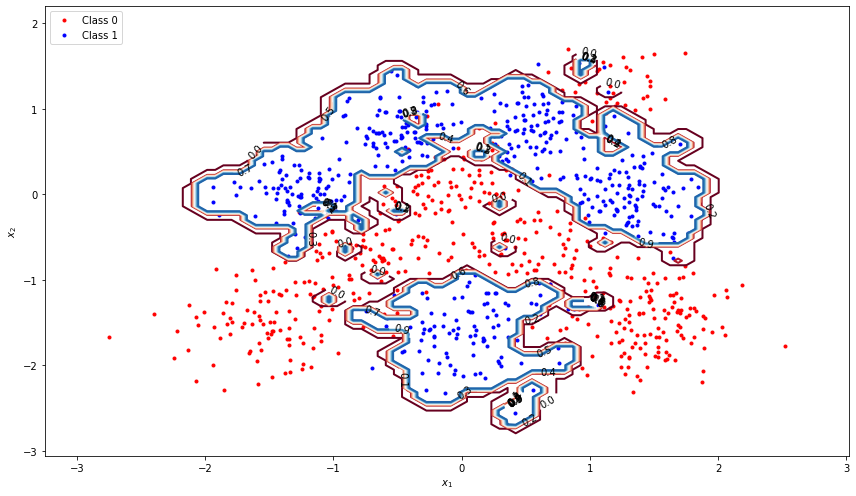

# MAP prediction:


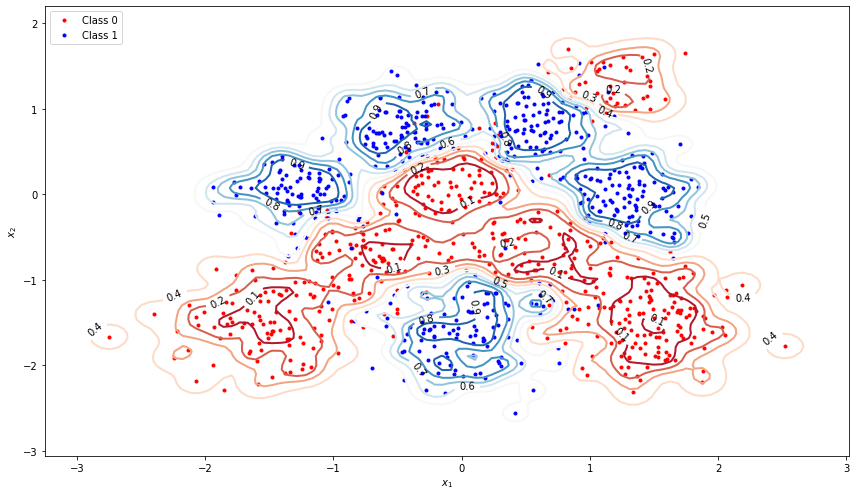

# Laplace prediction:


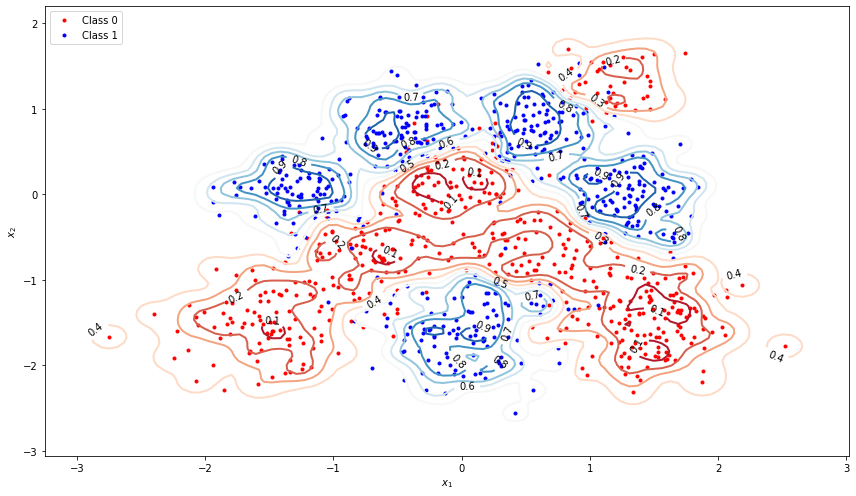

Confusion matrix (ML prediction, test set, rbf_width=0.1, prior_variance=1)
[[0.88990826 0.11009174]
 [0.20879121 0.79120879]]
Confusion matrix (MAP prediction, test set, rbf_width=0.1, prior_variance=1)
[[0.90825688 0.09174312]
 [0.13186813 0.86813187]]
Confusion matrix (Laplace prediction, test set, rbf_width=0.1, prior_variance=1)


/tmp/ipykernel_19149/3743801831.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


[[0.90825688 0.09174312]
 [0.13186813 0.86813187]]

Avg LL (w_ML, training set, rbf_width=0.1): 9.98612740221122e-06
Avg LL (w_ML, test set, rbf_width=0.1): -1.7844940353335588
Avg LL (w_MAP, training set, rbf_width=0.1): -0.21457695804293744
Avg LL (w_MAP, test set, rbf_width=0.1): -0.3108375327859008


In [16]:
generate_plots_and_performance_metrics(rbf_width=0.1, prior_variance=1)

## Optimising the hyperparameters

We need to find an optimal value for `rbf_width` and `prior_variance`.
To do this we will find the values that maximise the model evidence $p(X)$.

Find the evidence requires calculating the determinant of the Hessian. This often results in numerical errors, so use `np.linalg.slogdet` to find the log-determinant, which should avoid any problems.

In [17]:
def log_evidence(w, X, y, rbf_width, prior_variance):
    h = calculate_hessian(w, rbf_width, prior_variance)
    sign, logdet = np.linalg.slogdet(h)
    if np.exp(logdet) == 0:
        # If the determinant is 0, the approximation does not work
        return -np.inf
    return ((y.size/2)*log(2*np.pi) 
            - 0.5*logdet 
            + log_likelihood(w, X, y)
            + log_prior(w, prior_variance))

Perform grid search to find the optimal settings of the hyperparameters:

In [18]:
from tqdm.notebook import tqdm

def grid_search(rbf_widths, prior_variances, filename=None):
    grid = np.empty((len(rbf_widths), len(prior_variances)))
    with tqdm(total=len(rbf_widths) * len(prior_variances)) as progress_bar:
        for i, rbf_width in enumerate(rbf_widths):
            for j, prior_variance in enumerate(prior_variances):
                expanded_X_train = expand_inputs(rbf_width, X_train)    
                w_map = find_w_map(expanded_X_train, y_train, prior_variance)
                grid[i][j] = log_evidence(w_map, expanded_X_train, y_train, rbf_width, prior_variance)
                progress_bar.update(1)

    # Plot as a heatmap
    fig = plt.figure()
    ax = plt.gca()
    ax.set_xticks(np.arange(len(rbf_widths)), labels=rbf_widths)
    ax.set_yticks(np.arange(len(prior_variances)), labels=prior_variances)
    ax.set_xlabel("RBF Width")
    ax.set_ylabel(r"$\sigma_0^2$")
    heatmap = ax.imshow(grid.T)
    colorbar = fig.colorbar(heatmap, shrink=0.8, label='Approximate log-evidence')
    fig.tight_layout()
    if filename is not None:
        plt.savefig(filename, bbox_inches='tight', pad_inches=0)

Start with a coarse search to get the right order of magnitude:

  0%|          | 0/28 [00:00<?, ?it/s]

/tmp/ipykernel_19149/1936970050.py:4: RuntimeWarning: overflow encountered in exp
  if np.exp(logdet) == 0:


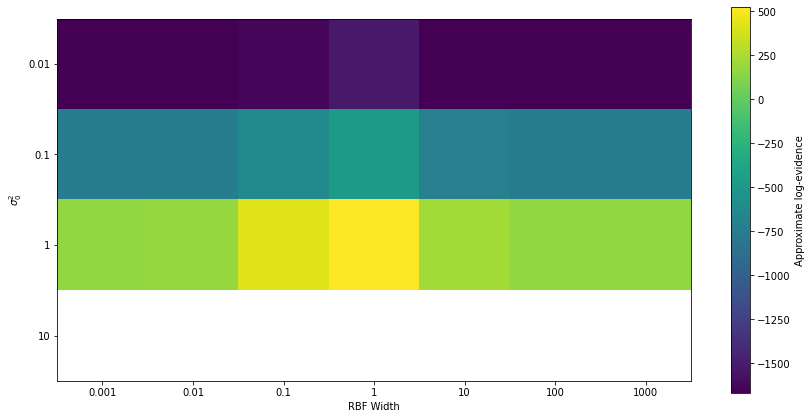

In [19]:
grid_search(rbf_widths=[0.001, 0.01, 0.1, 1, 10, 100, 1000],
            prior_variances=[0.01, 0.1, 1, 10],
            filename='plots/bayesian_logistic_classification/coarse_grid_evidence.png')

Perform a fine grid search around the most promising regions above:

  0%|          | 0/192 [00:00<?, ?it/s]

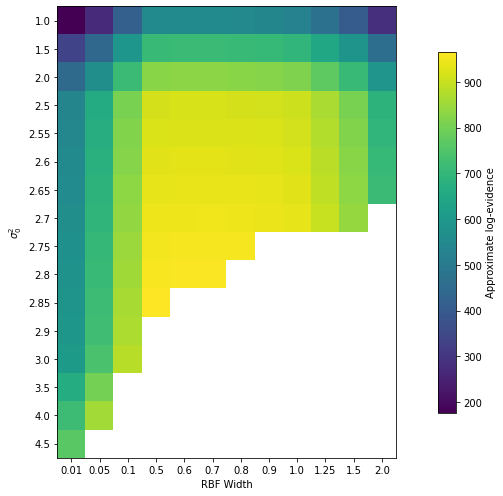

In [20]:
grid_search(rbf_widths=[0.01, 0.05, 0.1, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.25, 1.5, 2.0],
            prior_variances=[1.0, 1.5, 2.0, 2.5, 2.55, 2.6, 2.65, 2.7, 2.75, 2.8, 2.85, 2.9, 3.0, 3.5, 4.0, 4.5],
            filename='plots/bayesian_logistic_classification/fine_grid_evidence.png')

Pick some good values from the fine grid search and evaluate the model performance:

# ML prediction:


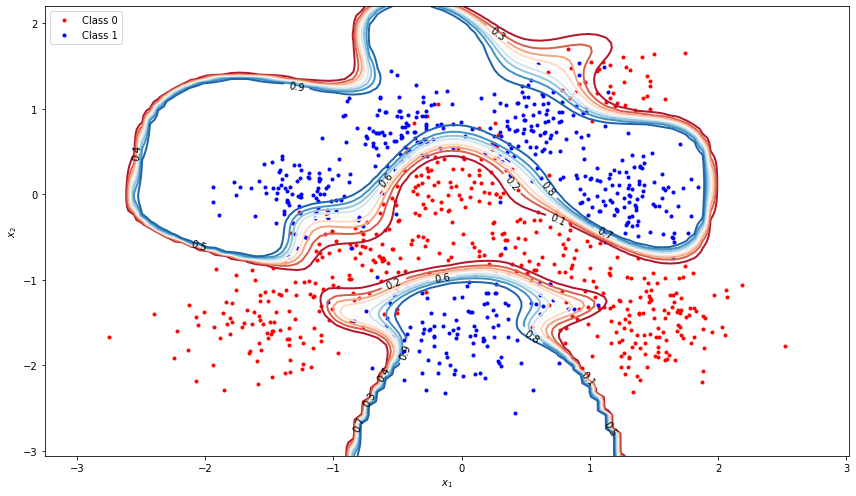

# MAP prediction:


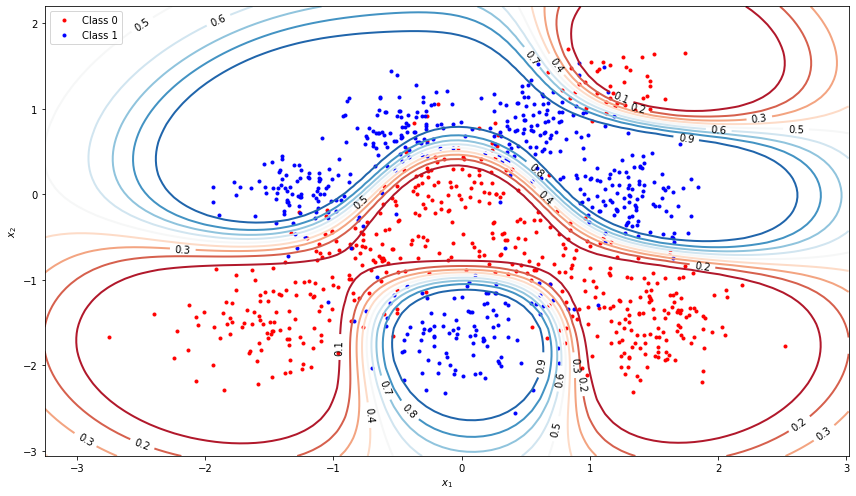

# Laplace prediction:


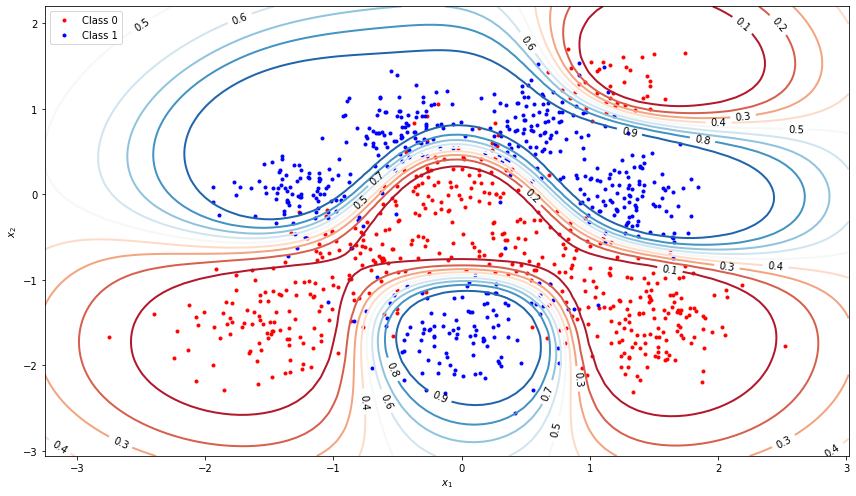

Confusion matrix (ML prediction, test set, rbf_width=0.7, prior_variance=2.8)
[[0.89908257 0.10091743]
 [0.10989011 0.89010989]]
Confusion matrix (MAP prediction, test set, rbf_width=0.7, prior_variance=2.8)
[[0.88990826 0.11009174]
 [0.07692308 0.92307692]]
Confusion matrix (Laplace prediction, test set, rbf_width=0.7, prior_variance=2.8)
[[0.88990826 0.11009174]
 [0.07692308 0.92307692]]

Avg LL (w_ML, training set, rbf_width=0.7): -0.14569458194784485
Avg LL (w_ML, test set, rbf_width=0.7): -0.2874989650059136
Avg LL (w_MAP, training set, rbf_width=0.7): -0.1742722261292603
Avg LL (w_MAP, test set, rbf_width=0.7): -0.2490077306136424


In [21]:
optimal_rbf_width = 0.7
optimal_prior_variance = 2.8
generate_plots_and_performance_metrics(optimal_rbf_width, optimal_prior_variance)